In this project a dataset of 3400 olive leaf images collected from Denizli city of Turkey during spring and summer are given. 
Three classes of these images: 
1. leaf images infected with Aculus olearius.
2. leaf images infected with Olive peacock spot.
3. leaf images with healthy leaves.

Tasks:
1. load and prepare images for modeling.
2. develop a convolutional neural network for image classification
3. develop a model for image classification using transfer learning

In [36]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics
import tensorflow as tf
import sys, os
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from matplotlib.image import imread

**Task1 load and prepare images for modeling.**

In [37]:
# Directory paths
TRAIN_DIR ='/content/drive/My Drive/Olives Dataset/Train/'
TEST_DIR ='/content/drive/My Drive/Olives Dataset/Test/'

# ROWS and COLS are the size of image. 
# The images will have to be reshaped prior to modeling so that all images have the same shape.
ROWS = 32
COLS = 32
CHANNELS = 3

**Plot aculus_olearius images**

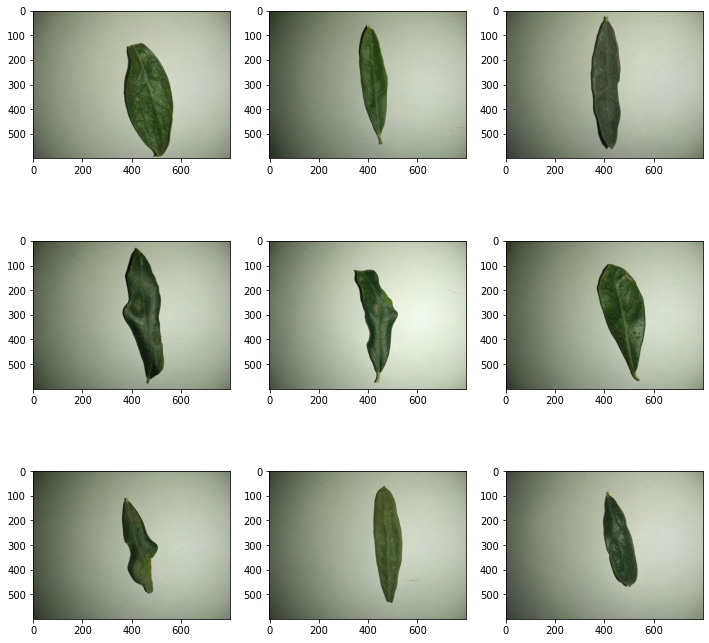

In [38]:
# load and plot the first nine images of aculus_olearius from train dataset
pyplot.figure(figsize=(12,12))
for i in range(1,10):
    # define subplot
    pyplot.subplot(330 + i)
    # define filename
    filename = TRAIN_DIR + 'aculus_olearius/aculus_olearius (' + str(i) + ').jpg'
    # load image pixels
    image = imread(filename)
    pyplot.imshow(image)
# show the figure
pyplot.show()

**Plot Healthy images**

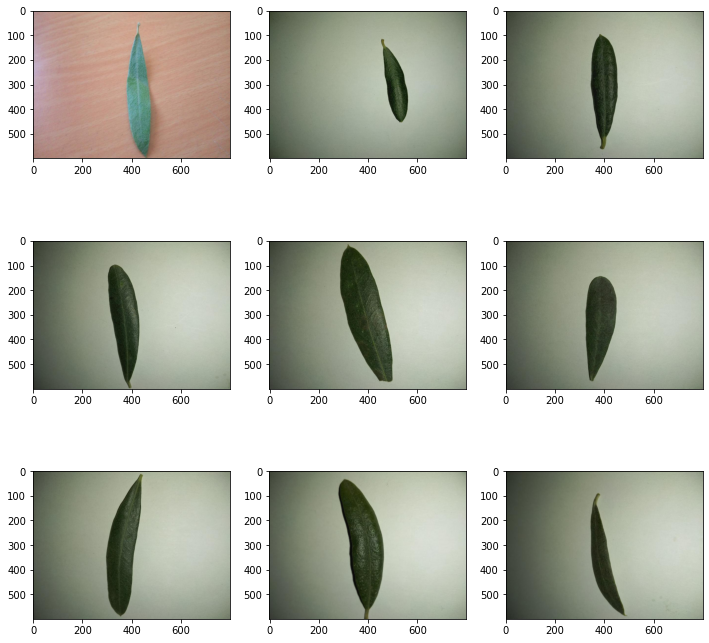

In [39]:
# load and plot the first nine photos of Healthy folder from train dataset
pyplot.figure(figsize=(12,12))
for i in range(1,10):
    # define subplot
    pyplot.subplot(330 + i)
    # define filename
    filename = TRAIN_DIR + 'Healthy/Healthy (' + str(i) + ').jpg'
    # load image pixels
    image = imread(filename)
    pyplot.imshow(image)
# show the figure
pyplot.show()

**Plot olive_peacock_spot images**

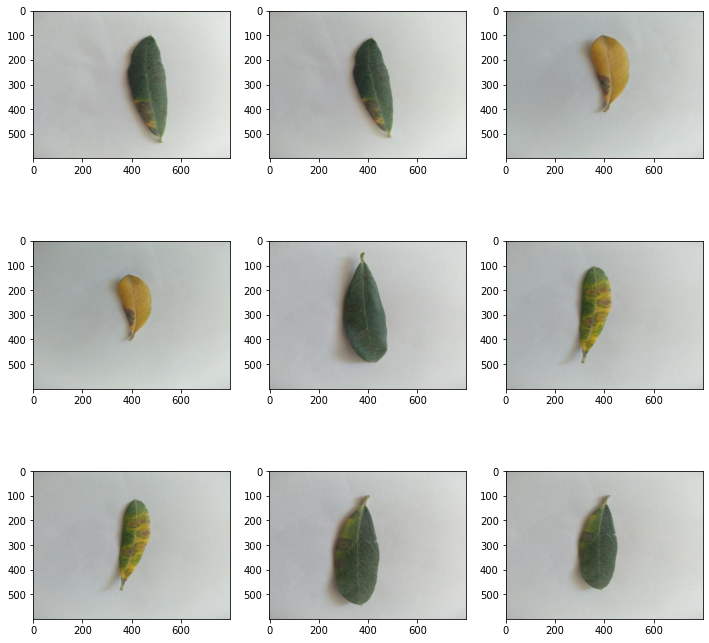

In [40]:
# load and plot the first nine photos of olive_peacock_spot folder from train dataset
pyplot.figure(figsize=(12,12))
for i in range(1,10):
    # define subplot
    pyplot.subplot(330 + i)
    # define filename
    filename = TRAIN_DIR + 'olive_peacock_spot/olive_peacock_spot (' + str(i) + ').jpg'
    # load image pixels
    image = imread(filename)
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [41]:
# Dataframe to store final results of models
dfResults = pd.DataFrame(columns=['Model','Accuracy', 'Precision','Recall','F1 score','Confusion matrix','ROC'])
dfResults

# load and open images 
def getdata(datapath):
    from PIL import Image
    data_list = []
    labels_list = []
    classes_list = ['aculus_olearius','Healthy','olive_peacock_spot']
    for i in range(len(classes_list)):
        file = classes_list[i]
        i_path = os.path.join(datapath, file) #0-42
        for img in os.listdir(i_path):
            if img.startswith(file):
                im = Image.open(i_path +'/'+ img)
                im = im.resize((COLS,ROWS))
                im = np.array(im)
                data_list.append(im)
                labels_list.append(i)
    data = np.array(data_list)
    labels = np.array(labels_list)
    return(data, labels)
  
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    print('*******************  PLot loss  *******************')
    fig, ax=plt.subplots(2,1,figsize=(12,10))
    pyplot.subplot(211)
    pyplot.tight_layout(h_pad=2)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.legend()
    # plot accuracy
    print('*****************  PLot accuracy ******************')
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.legend()
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()

# Evaluate the model based on accuray, precision, recall, F1 and ROC score
def evaluate_model(y_pred, model,modelname):
    from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    # print('Accuracy: {:.2f}%'.format(accuracy))
    precision = precision_score(y_true, y_pred,average='micro')
    print('Precision: {:.2f}%'.format(precision))
    recall = recall_score(y_true, y_pred, average='micro')
    print('Recall: {:.2f}%'.format( recall))
    f1 = f1_score(y_true, y_pred,average='micro')
    print('F1 score: {:.2f}%'.format( f1))

    # ROC AUC
    auc = roc_auc_score(y_true, model.predict(x_test, verbose=0),multi_class='ovr')
    print('ROC AUC:', auc)
    # confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    print("Confusion metrics",matrix)
    print('**********************************************************')
    print('*****************  Classification Report  ****************')
    print('**********************************************************')
    print(metrics.classification_report(y_true,y_pred))
    SaveResults(modelname,accuracy,precision,recall,f1,matrix,auc)

# Fit, evaluate and save results of the model
def fit_and_evaluate_model(model, modelname):
    # fit model
    history = model.fit(x_train, y_train, steps_per_epoch=len(x_train), validation_data=(x_test, y_test), validation_steps=len(x_test), epochs=20, verbose=0)
    # model accuracy
    Y_pred= model.predict(x_test)
    Y_pred = np.argmax(Y_pred, axis=1)
    print('**********************************************************')
    print('*******************  Model Evaluation  *******************')
    print('**********************************************************')
    print('Acuracy achieved: {:.2f}%\nAccuracy by model was: {:.2f}%\nAccuracy by validation was: {:.2f}%'.
        format(accuracy_score(y_true,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))
    evaluate_model(Y_pred, model,modelname)
    summarize_diagnostics(history)

# save the model evaluation in dataframe 
def SaveResults(modelname, accuracy, precision, recall, F1_score, confusion_matrix, roc):
    global dfResults
    dfResults.style.hide_index()
    if(dfResults[dfResults['Model']==modelname] is not np.empty):
    dfResults.drop(dfResults.loc[dfResults['Model']==modelname].index, inplace=True)
    new_results = {'Model': modelname, 
             'Accuracy': accuracy, 
             'Precision':precision, 
             'Recall':recall, 
             'F1 score':F1_score, 
             'Confusion matrix':confusion_matrix, 
             'ROC':roc,}
    #append row to the dataframe
    dfResults= dfResults.append(new_results, ignore_index=True)

# convert labels to categorical
def prep_dataset(X,y):
    X_prep = X.astype('float32')/255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

**Prepare Train data**

In [42]:
# load and open all the images from training data
data, labels = getdata(TRAIN_DIR)
# data and labels the images and target labels for train data
print(data.shape, labels.shape)

(2730, 32, 32, 3) (2730,)


In [43]:
# convert labels to categorical
x_train, y_train = prep_dataset(data,labels)

**Prepare Test data**

In [44]:
# testdata and testlabels the images and target labels for test data
testdata, testlabels = getdata(TEST_DIR)
print(testdata.shape, testlabels.shape)

(680, 32, 32, 3) (680,)


In [45]:
# convert labels to categorical
x_test, y_test = prep_dataset(testdata,testlabels)
y_true = np.argmax(y_test,axis=1)

In [46]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2730, 32, 32, 3), (2730, 3), (680, 32, 32, 3), (680, 3))

**Build One Block VGG Model**

define_model1() function builds one-block VGG model with a single convolutional layer with 32 filters followed by a max pooling layer and dropout of rate of 30%. The dropout is applied after each VGG block.

In [47]:
# define cnn model
def define_model1():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(COLS, ROWS, CHANNELS)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    model.summary()

    # compile model
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       36992     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)       

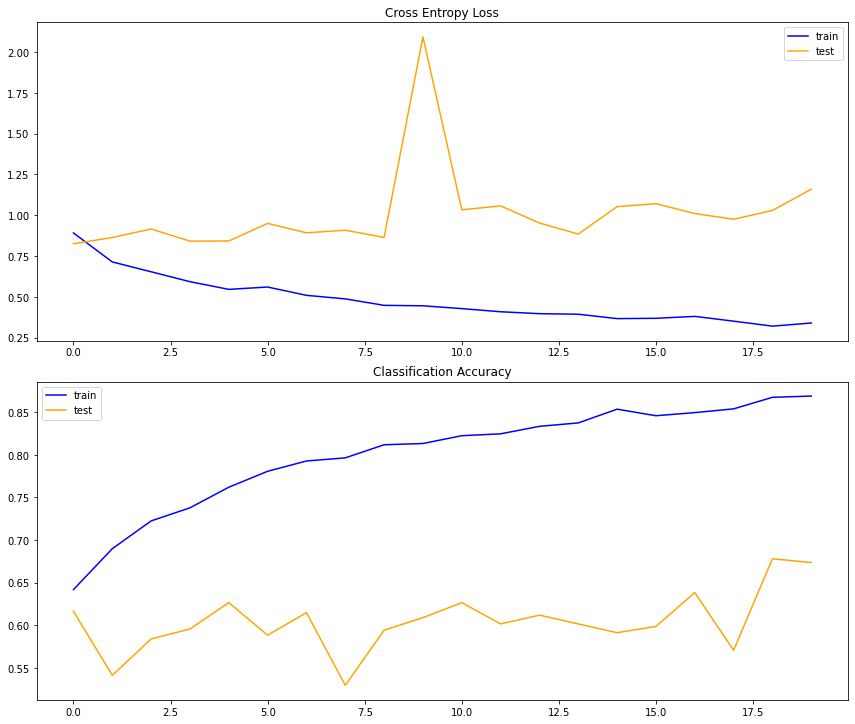

In [48]:
# fit and evaluate model
model1 = define_model1()
# fit_and_evaluate_model will first fits the model, then reports the model performance on the test dataset.
fit_and_evaluate_model(model1,'One Block VGG Model')

The accuracy of 1 Block vgg model is 67%. A figure is also created showing a line plot for the loss and another for the accuracy of the model on both the train (blue) and test (orange) datasets.

**Two Block VGG Model**

The two-block VGG model extends the one block model and adds a second block with 64 filters.

In [49]:
# define cnn model
def define_model2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(COLS, ROWS, CHANNELS)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    model.summary()

    # compile model
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 64)        

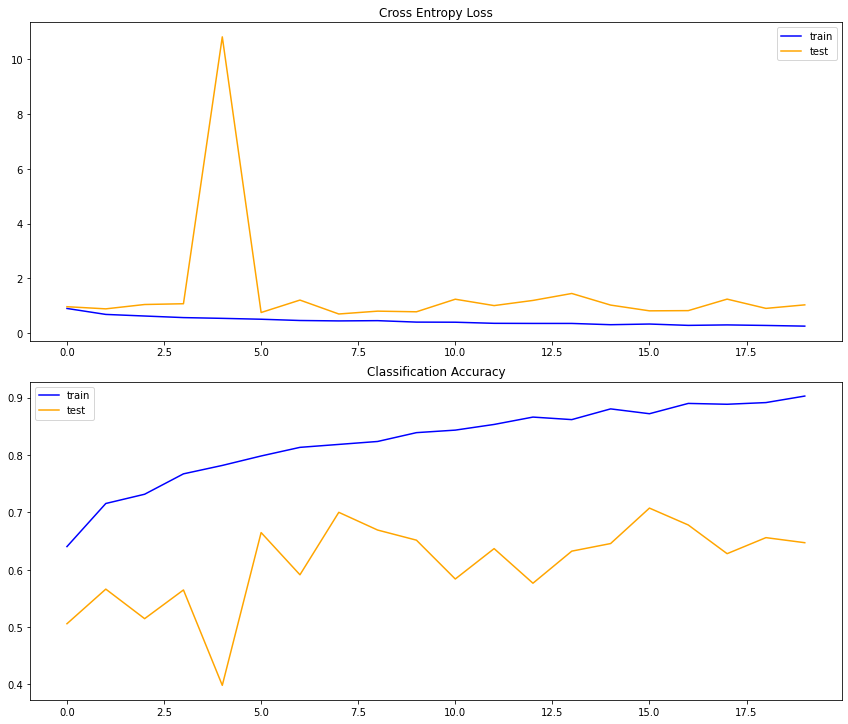

In [50]:
# define model
model2 = define_model2()
fit_and_evaluate_model(model2,'Two Block VGG Model')

The accuracy of 2 Block VGG model is 64%. A figure is also created showing a line plot for the loss and another for the accuracy of the model on both the train (blue) and test (orange) datasets.

**Three Block VGG Model**

The three-block VGG model extends the two block model and adds a third block with 128 filters.

In [51]:
# define cnn model
def define_model3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(COLS, ROWS, CHANNELS)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    model.summary()

    # compile model
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 64)        

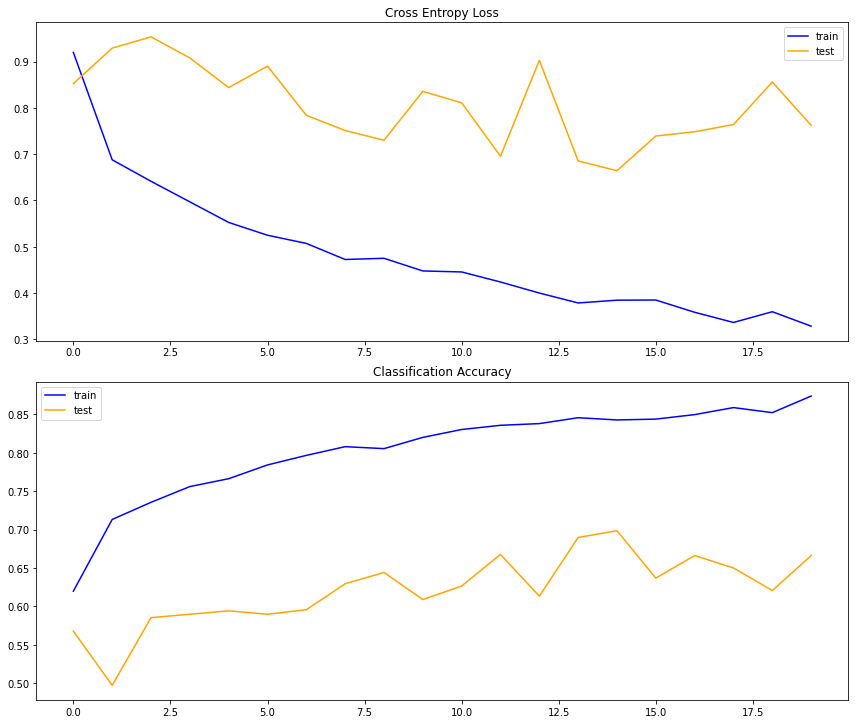

In [52]:
# define model
model3 = define_model3()
fit_and_evaluate_model(model3,'Three Block VGG Model')

The accuracy of 2 Block VGG model is 66%. A figure is also created showing a line plot for the loss and another for the accuracy of the model on both the train (blue) and test (orange) datasets.

**Develop a model for image classification using transfer learning**

A useful model for transfer learning is one of the VGG models, such as VGG-16 with 16 layers. The model has two parts, the feature extractor part of the model that is made up of VGG blocks, and the classifier part of the model that is made up of fully connected layers and the output layer. 

In [53]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_modelVGG16():
    # load model
    model = VGG16(include_top=False, input_shape=(COLS, ROWS, CHANNELS))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(3, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    # opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

22/22 [==============================] - 10s 452ms/step
**********************************************************
*******************  Model Evaluation  *******************
**********************************************************
Acuracy achieved: 77.06%
Accuracy by model was: 89.96%
Accuracy by validation was: 77.06%
Precision: 0.77%
Recall: 0.77%
F1 score: 0.77%
ROC AUC: 0.9147584836660924
Confusion metrics [[162  14  24]
 [ 16 171  33]
 [ 40  29 191]]
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.74      0.81      0.78       200
           1       0.80      0.78      0.79       220
           2       0.77      0.73      0.75       260

    accuracy                           0.77       680
   macro avg       0.77      0.77      0.77       680
weighted avg       0.77      0.77  

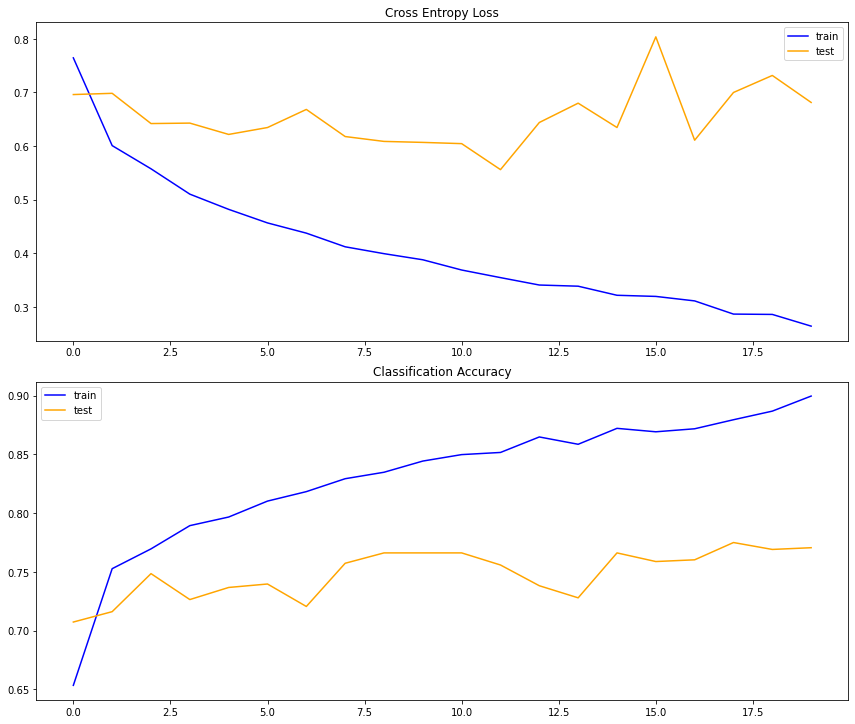

In [54]:
# define model
modelVGG16 = define_modelVGG16()
fit_and_evaluate_model(modelVGG16,'Transfer learning VGG16 Model')

**Compare the above classifiers models according to Accuracy, Precision, Recall, F1-Score, and ROC**

In [61]:
# Display the records for all the calssifiers
dfResults.head()

Model  Accuracy  Precision    Recall  F1 score  \
0            One Block VGG Model  0.673529   0.673529  0.673529  0.673529   
1            Two Block VGG Model  0.647059   0.647059  0.647059  0.647059   
2          Three Block VGG Model  0.666176   0.666176  0.666176  0.666176   
3  Transfer learning VGG16 Model  0.770588   0.770588  0.770588  0.770588   

                                Confusion matrix       ROC  
0  [[161, 23, 16], [69, 130, 21], [67, 26, 167]]  0.834003  
1    [[183, 11, 6], [116, 97, 7], [88, 12, 160]]  0.846220  
2   [[142, 23, 35], [39, 96, 85], [32, 13, 215]]  0.862405  
3  [[162, 14, 24], [16, 171, 33], [40, 29, 191]]  0.914758

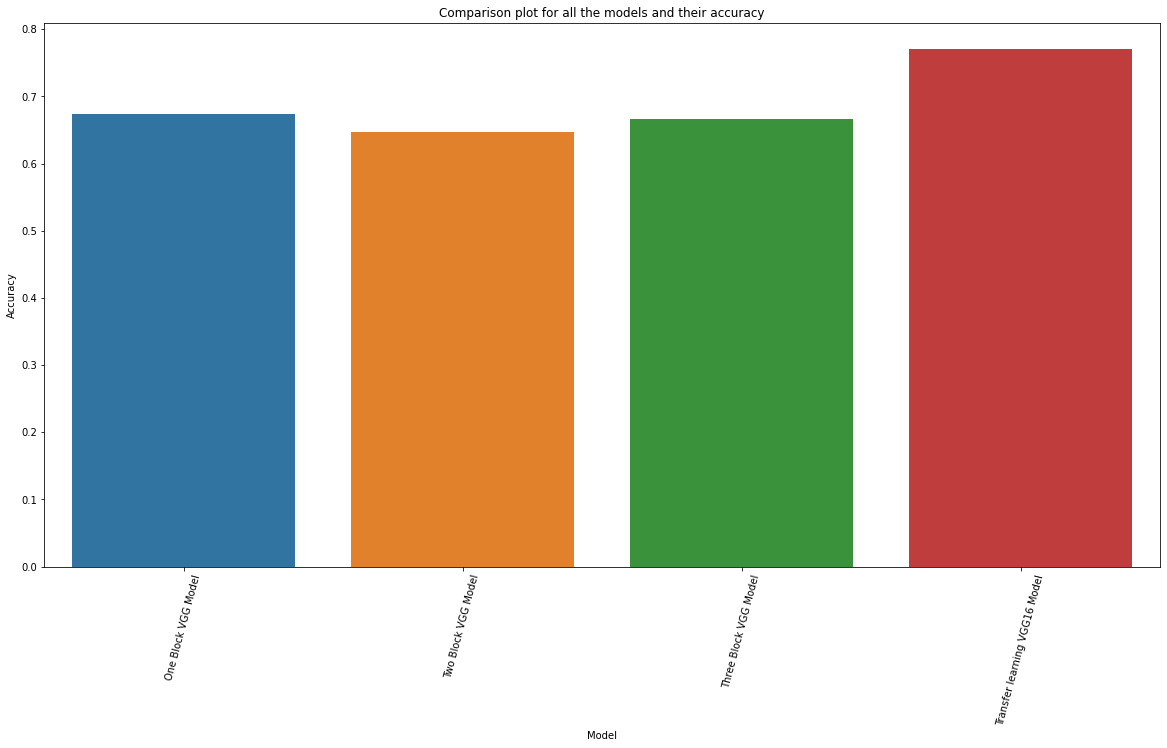

In [62]:
plt.figure(figsize=(20,10))
ax= sns.barplot(x = dfResults.Model,y = dfResults.Accuracy, data=dfResults)

ax.set_xticklabels(dfResults.Model,rotation = 75)
ax.set_title('Comparison plot for all the models and their accuracy')
plt.show()

From the above results we can see that transfer learning with VGG16 model performed the best with accuracy 77%. We will save this model to predict the class of the sample image.

**Save the best Model with pickle**

In [55]:
# save model
modelVGG16.save('final_model.h5')

**Load the saved mode to predict**

1/1 [==============================] - 0s 192ms/step
[2]


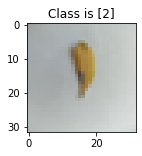

In [86]:
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from PIL import Image
 
# load and prepare the image
def load_image(filename):
  # load the image
  data_list = []
  im = Image.open(filename)
  im = im.resize((COLS,ROWS))
  im = np.array(im)
  data_list.append(im)
  img = np.array(data_list)
  img = img.astype('float32')/255
  return img
 
# load an image and predict the class
def predict_class(filename):
  # load the image
  img = load_image('/content/drive/MyDrive' +'/'+ filename)

  # load model
  model = load_model('final_model.h5')
  # predict the class
  result = np.argmax(model.predict(img),axis=1) 
  plt.figure(figsize=(4,2))
  img = img.reshape(COLS, ROWS, CHANNELS)
  plt.imshow(img, cmap="binary", interpolation="nearest")
  print(result)
  plt.title("Class is {}".format(result))
  plt.show()
 
 
# entry point, run the example
predict_class('olive_peacock_spot.jpg')

**The predicted result is 2 which means that the leaf is of class olive_peacock_spot**